# Warehouse Optimization (Model Only)

## Initilization

In [75]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas_profiling
import numpy as np
data = pd.read_csv('ML_datafile_Final.csv')
data.reset_index(drop=True, inplace=True)
data = data[data['Soldout/not'] == 'Sold'].copy()
data = data.drop(['Item No', 'Manufacturer No', 'Product Name', 'Date', 'STOCK TYPE', 'In Stock', 'List No',
                 'UPC Code', 'Profit','Soldout/not','Sold_day', 'Sold','Blowout','Unnamed: 0'	 ], axis=1)
data

,Manufacturer,Category,Category Path 1,Category Path 2,Category Path 3,Price(USD),Cost price,Inventory,Shipping,weight(lb),Qty_Remaining,SaleRate
0,iMicro,Cartridge & Toner,Hardware & Software,Printer & Scanner,Cartridge & Toner,17.94,13.455,3,2.5,1.48,0,0.500000
1,Cougar,Mouse Pad,Component,Input & Output Device,Mouse Pad,20.50,15.375,3,2.5,1.00,0,0.500000
2,ASUS,Wireless Router,Component,Networking,Wireless Networking,25.62,19.215,3,2.5,1.02,0,0.500000
3,Dynatron,Server,Component,Fan & Heatsink,CPU Fan & Heatsink,32.80,24.600,3,2.5,0.99,0,0.500000
4,Linksys,Wireless Router,Component,Networking,Wireless Networking,41.00,30.750,3,2.5,1.40,0,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
4195,SUPER TALENT,Server DDR3,Component,DRAM Memory,Server DRAM,76.88,57.660,1,0.0,0.08,0,0.011111
4196,QNAP,Server,Component,Power Supply,Server,142.00,106.500,1,2.5,3.00,0,0.011111
4197,Supermicro,1U,Component,Server,Server Barebone,105.00,78.750,1,0.0,0.00,0,0.011111
4198,Supermicro,Accessory,Hardware & Software,Server & Workstation,Accessory,119.92,89.940,1,2.5,2.00,0,0.011111


In [76]:
# limit to categorical data
nominal_data = data.select_dtypes(include=[object])
ordinal_data = data.drop(list(nominal_data.columns), axis=1)
nominal_data = nominal_data.replace(np.nan, 'Default', regex=True)
ordinal_data.reset_index(drop=True, inplace=True)

## One-Hot Encoding

In [77]:
from sklearn import preprocessing
nominal_data_2 = nominal_data
# 1. INSTANTIATE
enc = preprocessing.OneHotEncoder()
# 2. FIT
enc.fit(nominal_data_2)
# 3. Transform
onehotlabels = enc.transform(nominal_data_2).toarray()
onehotlabels = pd.DataFrame(onehotlabels)
onehotlabels.reset_index(drop=True, inplace=True)
print(onehotlabels.shape)

(3770, 450)


In [79]:
encoded_data = pd.concat([ordinal_data, onehotlabels], axis=1)

In [81]:
#Library Import
import random
import pandas as pd
import numpy as np
import pickle
from math import sqrt
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import validation_curve

## Data Split

In [82]:
X = encoded_data.drop('SaleRate', axis=1)
Y = encoded_data['SaleRate']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state = 1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size= 0.5, random_state = 1)
X_train.head(5)

,Price(USD),Cost price,Inventory,Shipping,weight(lb),Qty_Remaining,0,1,2,3,...,440,441,442,443,444,445,446,447,448,449
993,271.63,203.7225,40,2.5,1.50,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
231,25.62,19.2150,12,0.0,0.06,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
314,50.22,37.6650,14,2.5,2.30,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2957,15.89,11.9175,279,2.5,0.33,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
340,11.79,8.8425,11,2.5,0.47,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Training with validation 

In [97]:
from matplotlib import pyplot as plt
%matplotlib inline

def train(models, X, Y, iterations = 5, X_train = X_train,  y_train = y_train, X_val = X_val, y_val = y_val):
    results = {}
    for i in models:
        print("\nRunning ", i)
        r2_train = []
        r2_val = []
        mae_train = []
        mae_val = []
        mse_train = []
        mse_val = []
        mabe_train = []
        mabe_val = []
        mevs_train = []
        mevs_val = []
        for j in range(1, iterations):
            print(j, end='')
            h = int(4200/iterations*j)
            r2_val.append(metrics.r2_score(y_val,
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_val)))
            r2_train.append(metrics.r2_score(y_train, 
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_train)))
            mae_val.append(metrics.mean_absolute_error(y_val,
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_val)))
            mae_train.append(metrics.mean_absolute_error(y_train, 
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_train)))
            mse_val.append(metrics.mean_squared_error(y_val,
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_val)))
            mse_train.append(metrics.mean_squared_error(y_train, 
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_train)))
            mabe_val.append(metrics.median_absolute_error(y_val,
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_val)))
            mabe_train.append(metrics.median_absolute_error(y_train, 
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_train)))
            mevs_val.append(metrics.explained_variance_score(y_val,
                                            models[i].fit(X_train.head(h), 
                                                         y_train.head(h)).predict(X_val)))
            mevs_train.append(metrics.explained_variance_score(y_train, 
                                            models[i].fit(X_train.head(h), 
                                                    y_train.head(h)).predict(X_train)))
            
#R2 score
        fig, ax = plt.subplots()       
        plt.xlabel('Iterations') 
        plt.ylabel('Score') 
        ax.plot(r2_train, label='train')
        ax.plot(r2_val, label='test')
        plt.title("r2_val-train_score " + i)
        ax.legend()
        plt.figure()
#mae
        fig, ax = plt.subplots() 
        plt.xlabel('Iterations') 
        plt.ylabel('Score')
        ax.plot(mae_train, label='train')
        ax.plot(mae_val, label='test')
        plt.title("mean_absolute_error_train-val " + i)
        ax.legend()
        plt.figure()
#mse
        fig, ax = plt.subplots() 
        plt.xlabel('Iterations') 
        plt.ylabel('Score')
        ax.plot(mse_train, label='train')
        ax.plot(mse_val, label='val')
        plt.title("mean_squared_error_train-val " + i)
        ax.legend()
        plt.figure()
#mabe        
        fig, ax = plt.subplots() 
        plt.xlabel('Iterations') 
        plt.ylabel('Score')
        ax.plot(mabe_train, label='train')
        ax.plot(mabe_val, label='val')
        plt.title("median_absolute_error_train-val " + i)
        ax.legend()
        plt.figure()
#mevs
        fig, ax = plt.subplots()
        plt.xlabel('Iterations') 
        plt.ylabel('Score')
        ax.plot(mevs_train, label='train')
        ax.plot(mevs_val, label='val')
        plt.title("explained_variance_score_train-val " + i)
        ax.legend()
        plt.figure()
        
        results[i] = [r2_val[-1],r2_train[-1],mae_val[-1],mae_train[-1],mse_val[-1],mse_train[-1],mabe_val[-1],mabe_train[-1],
                      mevs_val[-1],mevs_train[-1]]
    return pd.DataFrame(results), models

In [98]:
models = {'ElasticNet': linear_model.ElasticNet(),
          'Lasso': linear_model.Lasso(),
          'Ridge': linear_model.Ridge(),
          'GBM': GradientBoostingRegressor(),
          'ada': AdaBoostRegressor(),
          'RFR':RandomForestRegressor()}


Running  ElasticNet
1
Running  Lasso
1
Running  Ridge
1
Running  GBM
1
Running  ada
1
Running  RFR
1Wall time: 49.9 s


,ElasticNet,Lasso,Ridge,GBM,ada,RFR
0,0.686920,0.687587,0.697980,0.894321,0.898907,0.874285
1,0.748480,0.748424,0.773774,0.950476,0.937139,0.967776
2,0.392217,0.392991,0.385416,0.182471,0.195882,0.189283
3,0.394896,0.395868,0.362344,0.148541,0.169365,0.102137
4,0.303584,0.302937,0.292859,0.102503,0.098605,0.113352
5,0.295135,0.295200,0.265455,0.058265,0.077704,0.037897
6,0.327154,0.331148,0.270280,0.063644,0.097886,0.068291
7,0.324569,0.328782,0.265856,0.056389,0.076195,0.029816
8,0.687341,0.687995,0.698165,0.894595,0.895291,0.881134
9,0.748530,0.748475,0.773774,0.950515,0.936925,0.968607


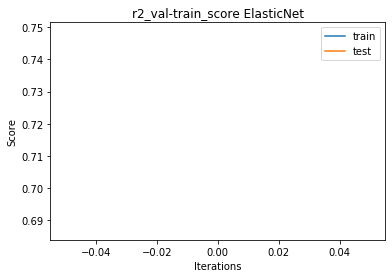

<Figure size 432x288 with 0 Axes>

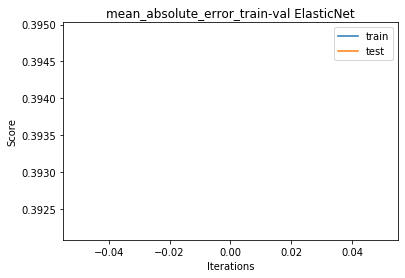

<Figure size 432x288 with 0 Axes>

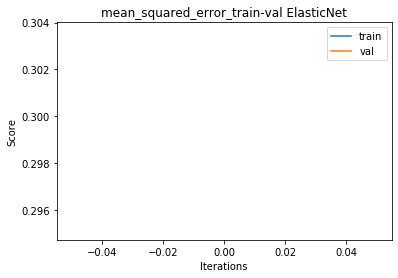

<Figure size 432x288 with 0 Axes>

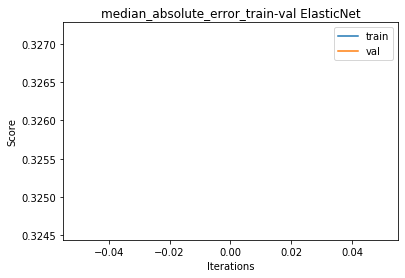

<Figure size 432x288 with 0 Axes>

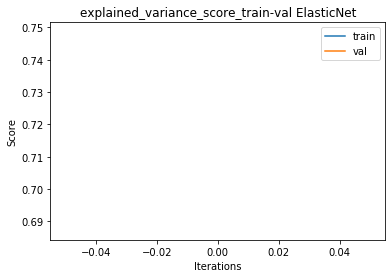

<Figure size 432x288 with 0 Axes>

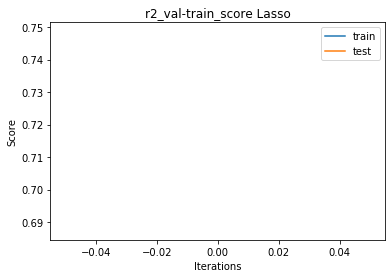

<Figure size 432x288 with 0 Axes>

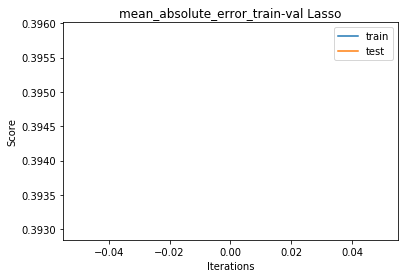

<Figure size 432x288 with 0 Axes>

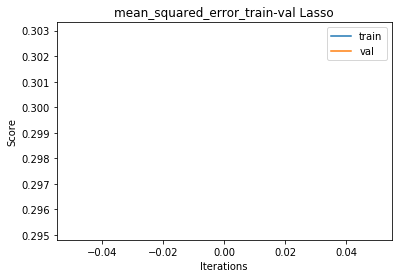

<Figure size 432x288 with 0 Axes>

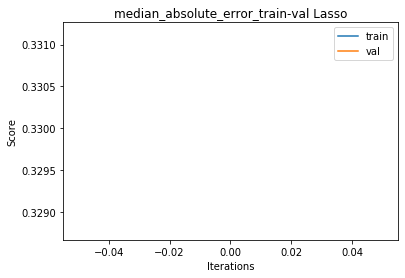

<Figure size 432x288 with 0 Axes>

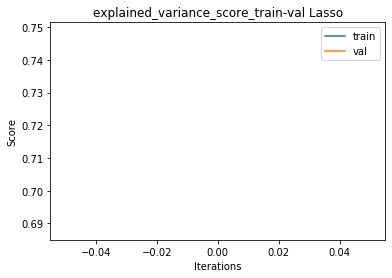

<Figure size 432x288 with 0 Axes>

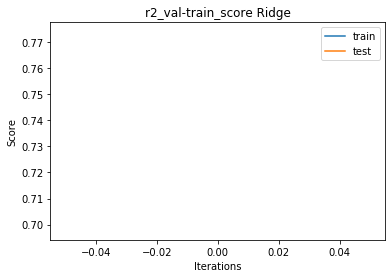

<Figure size 432x288 with 0 Axes>

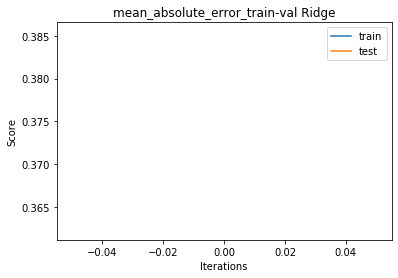

<Figure size 432x288 with 0 Axes>

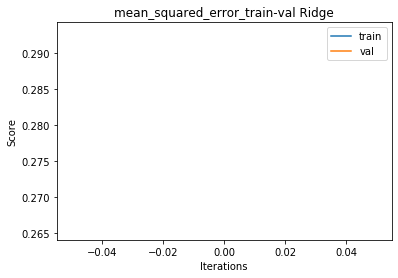

<Figure size 432x288 with 0 Axes>

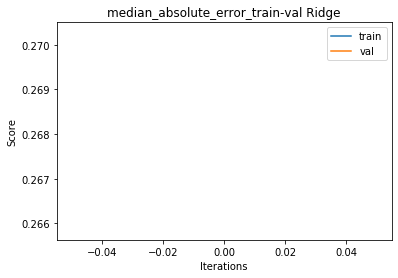

<Figure size 432x288 with 0 Axes>

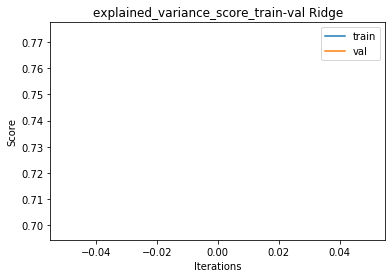

<Figure size 432x288 with 0 Axes>

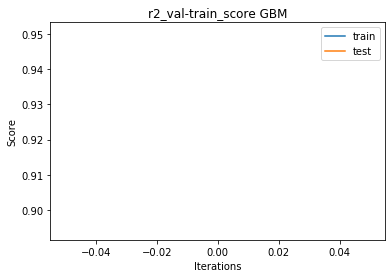

<Figure size 432x288 with 0 Axes>

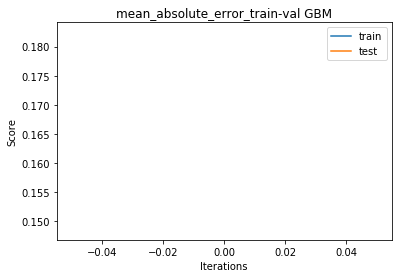

<Figure size 432x288 with 0 Axes>

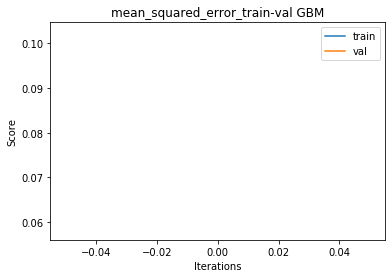

<Figure size 432x288 with 0 Axes>

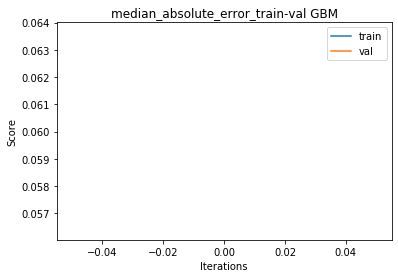

<Figure size 432x288 with 0 Axes>

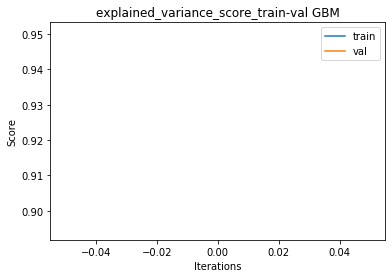

<Figure size 432x288 with 0 Axes>

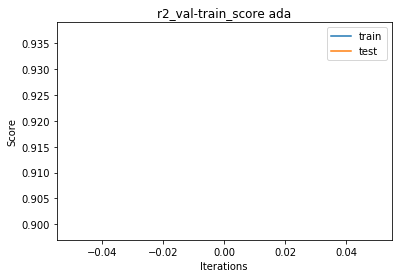

<Figure size 432x288 with 0 Axes>

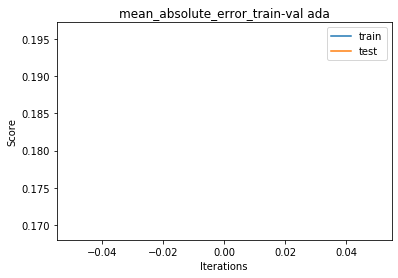

<Figure size 432x288 with 0 Axes>

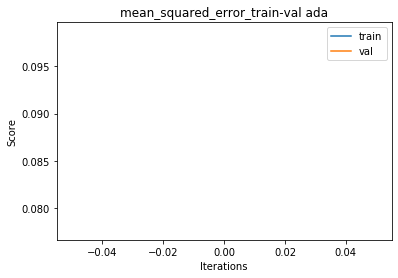

<Figure size 432x288 with 0 Axes>

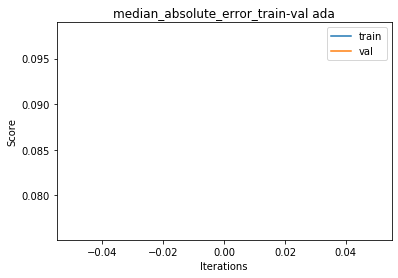

<Figure size 432x288 with 0 Axes>

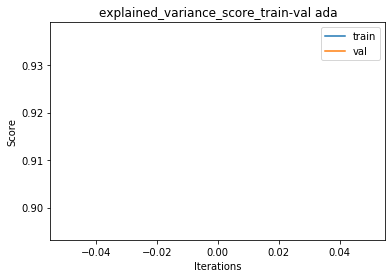

<Figure size 432x288 with 0 Axes>

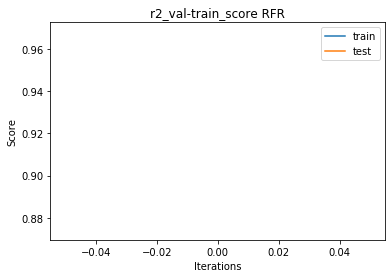

<Figure size 432x288 with 0 Axes>

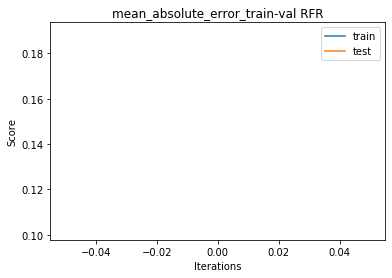

<Figure size 432x288 with 0 Axes>

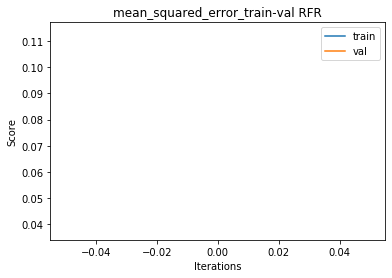

<Figure size 432x288 with 0 Axes>

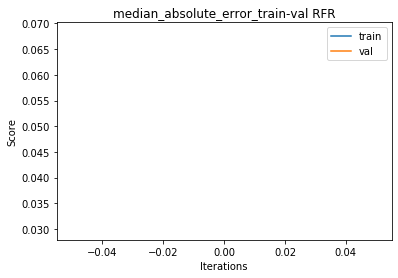

<Figure size 432x288 with 0 Axes>

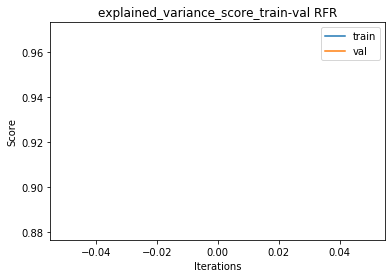

<Figure size 432x288 with 0 Axes>

In [99]:
%time result, models = train(models, X, Y, iterations=2)
result

#### Save and Load Machine Learning Models

In [101]:
from joblib import dump, load
for model in models.keys():
    dump(models[model], model + 'SoldOut'+ '.joblib')

#### Model prediction with Testing

In [102]:
#model prediction with testing
from matplotlib import pyplot as plt
%matplotlib inline

def test2(models, X, Y, iterations = 2, X_train = X_train,  y_train = y_train, X_test = X_test, y_test = y_test):
    results = {}
    for i in models:
        print("\nRunning ", i)
        table = dict()
        for j in range(1, iterations):
            print(j, end='')
            table['r2_test'] = metrics.r2_score(y_test, models[i].predict(X_test))
            table['r2_train'] = metrics.r2_score(y_train, models[i].predict(X_train))
            table['mae_test'] = metrics.mean_absolute_error(y_test, models[i].predict(X_test))
            table['mae_train'] = metrics.mean_absolute_error(y_train, models[i].predict(X_train))
            table['mse_test'] = metrics.mean_squared_error(y_test, models[i].predict(X_test))
            table['mse_train'] = metrics.mean_squared_error(y_train, models[i].predict(X_train))
            table['mabe_test'] = metrics.median_absolute_error(y_test, models[i].predict(X_test))
            table['mabe_train'] = metrics.median_absolute_error(y_train, models[i].predict(X_train))
            table['mevs_test'] = metrics.explained_variance_score(y_test, models[i].predict(X_test))
            table['mevs_train'] = metrics.explained_variance_score(y_train, models[i].predict(X_train))
            table['rmse_train'] = sqrt(table['mse_train'])
            table['rmse_test'] = sqrt(table['mse_test'])
            
            #R2 score
        fig, ax = plt.subplots()       
        plt.xlabel('Iterations') 
        plt.ylabel('Score') 
        ax.plot(table['r2_test'], label='train')
        ax.plot(['r2_train'], label='test')
        plt.title("r2_val-train_score " + i)
        ax.legend()
        plt.figure()
             
        results[i] = table
    return pd.DataFrame(results), models

In [103]:
from joblib import dump, load
models = {'ElasticNet': load('ElasticNetSoldOut.joblib'),
          'Lasso': load('LassoSoldOut.joblib'), 
          'Ridge': load('RidgeSoldOut.joblib'),
          'ada'  : load('adaSoldOut.joblib'),
          'GBM'  : load('GBMSoldOut.joblib'),
          'RFR'  : load('RFRSoldOut.joblib')}


Running  ElasticNet
1
Running  Lasso
1
Running  Ridge
1
Running  ada
1
Running  GBM
1
Running  RFR
1Wall time: 1.89 s


,ElasticNet,Lasso,Ridge,ada,GBM,RFR
r2_test,0.761328,0.761832,0.742755,0.939573,0.948984,0.937063
r2_train,0.748480,0.748424,0.773774,0.936911,0.950510,0.968607
mae_test,0.396389,0.397359,0.394807,0.183384,0.159369,0.178116
mae_train,0.394896,0.395868,0.362344,0.176905,0.148634,0.100373
mse_test,0.297755,0.297127,0.320925,0.075385,0.063645,0.078517
mse_train,0.295135,0.295200,0.265455,0.074030,0.058072,0.036837
mabe_test,0.320512,0.323231,0.292413,0.091933,0.062273,0.083289
mabe_train,0.324569,0.328782,0.265856,0.084378,0.056389,0.031737
mevs_test,0.761377,0.761884,0.742843,0.939980,0.949391,0.937345
mevs_train,0.748530,0.748475,0.773774,0.936925,0.950515,0.968607


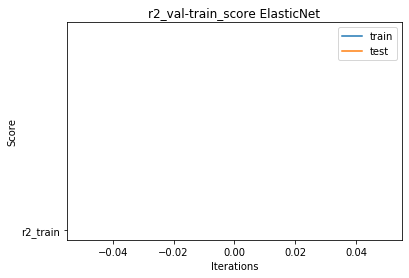

<Figure size 432x288 with 0 Axes>

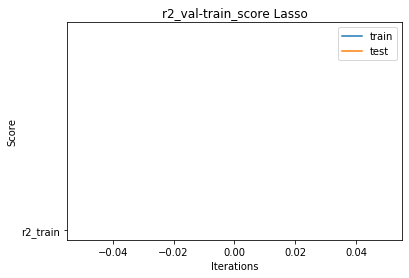

<Figure size 432x288 with 0 Axes>

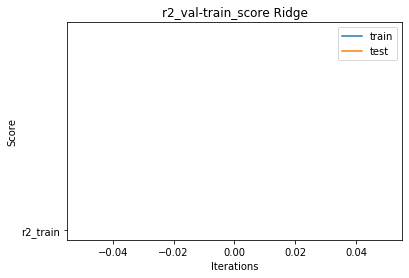

<Figure size 432x288 with 0 Axes>

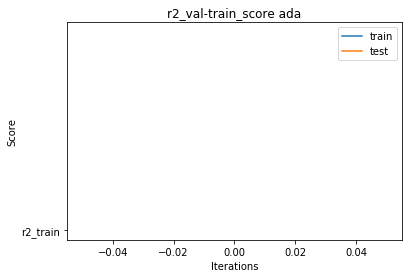

<Figure size 432x288 with 0 Axes>

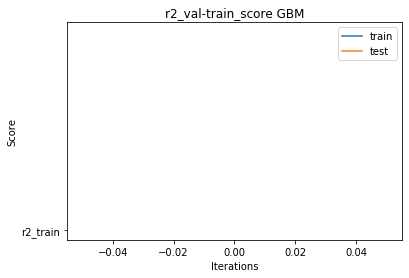

<Figure size 432x288 with 0 Axes>

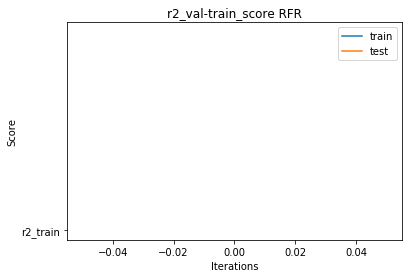

<Figure size 432x288 with 0 Axes>

In [104]:
%time result, models = test2(models, X, Y)
result

In [ ]:
model_
%time result, models = test2(models, X, Y)
result

In [105]:
import seaborn as sb

r2_test


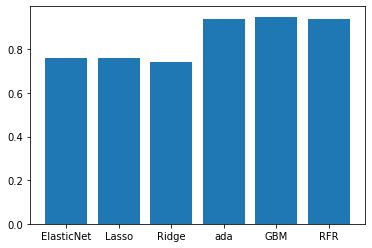

r2_train


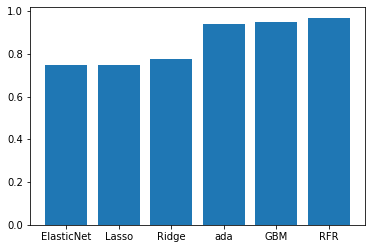

mae_test


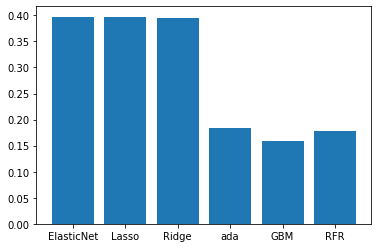

mae_train


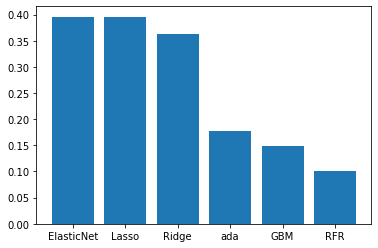

mse_test


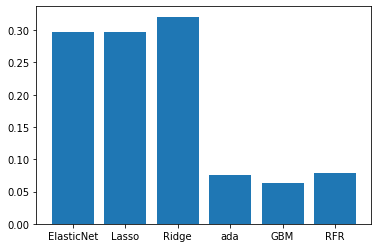

mse_train


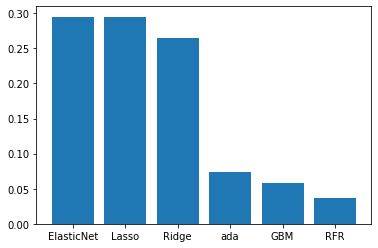

mabe_test


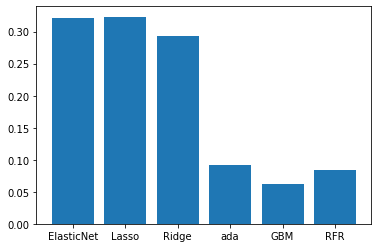

mabe_train


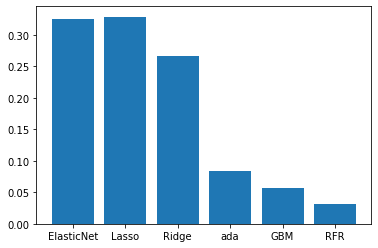

mevs_test


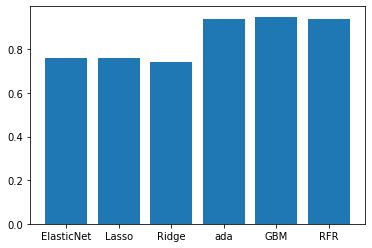

mevs_train


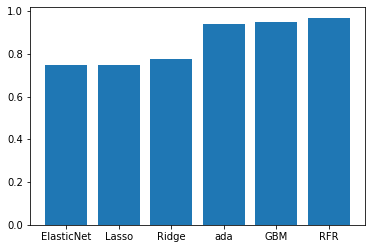

rmse_train


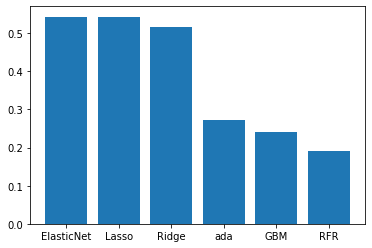

rmse_test


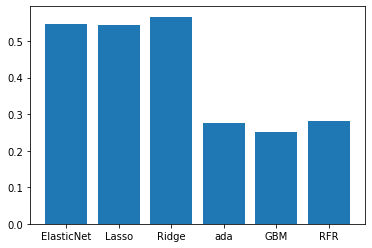

In [106]:
import matplotlib.pyplot as plt
result = result.transpose()
for key in result:
    print(key)
    plt.bar(range(len(dict(result[key]))), list(dict(result[key]).values()), align='center')
    plt.xticks(range(len(dict(result[key]))), list(dict(result[key]).keys()))
    plt.show()

#### Number of days prediction (i.e Blowout period)

In [107]:
y_pred = models['GBM'].predict(X_test)
print(y_pred[:10])
print(y_test.head(10))

[1.14496373 1.1863648  4.33932164 1.12102679 0.04177884 3.89940522
 0.12249903 6.05787421 1.14639312 0.1289639 ]
3604    1.275000
790     1.160000
2871    3.909091
581     0.941176
1768    0.046512
773     4.560000
2348    0.104167
3254    6.226190
3476    1.200000
2472    0.113208
Name: SaleRate, dtype: float64


In [109]:
#blowout period identification using best performing algorithm
X_test['y_pred'] = y_pred
X_test['blowout_pred'] = pd.DataFrame({"Days" : (X_test.Inventory - X_test.Qty_Remaining)  / X_test['y_pred']})
X_test['blowout'] = pd.DataFrame({"Days" : (X_test.Inventory - X_test.Qty_Remaining) / y_test})
X_test.head(10)

,Price(USD),Cost price,Inventory,Shipping,weight(lb),Qty_Remaining,0,1,2,3,...,443,444,445,446,447,448,449,y_pred,blowout_pred,blowout
3604,55.35,41.5125,51,2.5,7.50,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.144964,44.542896,40.0
790,27.67,20.7525,29,2.5,0.55,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.186365,24.444420,25.0
2871,2.67,2.0025,258,0.0,0.10,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.339322,59.456298,66.0
581,78.93,59.1975,16,2.5,0.20,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.121027,14.272629,17.0
1768,203.98,152.9850,2,2.5,2.85,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041779,47.871123,43.0
773,155.80,116.8500,114,2.5,0.67,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.899405,29.235228,25.0
2348,1103.93,827.9475,5,10.0,35.00,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122499,40.816648,48.0
3254,6.15,4.6125,523,0.0,0.18,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.057874,86.333915,84.0
3476,35.88,26.9100,12,0.0,0.09,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.146393,10.467613,10.0
2472,876.37,657.2775,6,2.5,0.31,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.128964,46.524649,53.0
